# Energy Consumption Prediction

This notebook explains the approach taken to analyze the data and make the necessary assumptions to build a model that predicts the energy consumption of a household. Let's first define the business problem that we are aiming to solve. 

## Business Problem
Given various information and characteristics about the household, design a model to predict the energy consumption.

## About the data

Residential Energy Consumption Survey (RECS) is a national sample survey that collects energy-related data for housing units occupied as primary residences and the households that live in them. We are going to use the RECS 2009 data which was collected from 12,083 households. Our goal is to predict the energy consumption in Kilowatt-hour.

## Overview

The approach to solving this problem is as follows,


1.  Preprocess the csv files and store them in an SQLite database for future use.
2.  Fetch the preprocessed data and analyze it to understand the data and make relevant assumptions.
3.  Clean the data based on the assumptions.
4.  Analyze the relationship between the features and understand its characteristics to select the correct model type.
5.  Model selection and training.
6.  Hyperparameter tuning to improve the performance of the model.

**Note: The cleaned version of this code can be found in the attached folder which contains the necessary classes and methods to make the predictions**

**Requirements - Upload two files 'recs2009_public.csv' and 'recs2009_public_codebook.xlsx' to the Google Colab before executing the code. The two required files can be found in the attached folder**




## 1. Preprocessing the data

The given data consists of a lot features and the column data types are ambiguous. So let's first preprocess the data and store it in a sql database.

In [4]:
import pandas as pd
from pathlib import Path
import sqlite3
from sqlite3 import Error
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import warnings
from scipy.stats import kurtosis, skew, boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Lasso,LassoCV
from yellowbrick.regressor import ResidualsPlot

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('recs2009_public.csv')
data.columns = [column.lower().strip().replace(' ','_') for column in data.columns]
data.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,doeid,regionc,division,reportable_domain,typehuq,nweight,hdd65,cdd65,hdd30yr,cdd30yr,...,scaleker,iecc_climate_pub,hdd50,cdd80,gnd_hdd65,wsf,oa_lat,gwt,designdbt99,designdbt1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


### Observation:

* The dataset consists of 938 features, 1 target variable 'kwh' and one id 
column 'doeid'. 
* What do these columns mean? How can we explain each feature  to the client or the management? 

*To* answer these questions, let's first analyze the "recs2009_public_codebook.xlsx" file which contains information about all the variables, their data type and range.

In [ ]:
# Load the variable information file and remove the uncessary columns
variable_enum = pd.read_excel('recs2009_public_codebook.xlsx', sheet_name='Codebook', header = None)
variable_enum.columns = variable_enum.iloc[1]
variable_enum.drop(variable_enum.index[1])
variable_enum = variable_enum.iloc[3:,:4]
variable_enum.rename(columns = {list(variable_enum)[3]:'Response Labels'}, inplace=True)
variable_enum.columns = [column.lower().replace(' ','_').strip() for column in variable_enum.columns]
variable_enum['response_codes_and_labels'] = variable_enum['response_codes_and_labels'].str.strip()
variable_enum.head(5)

,variable_name,variable_description,response_codes_and_labels,response_labels
3,DOEID,Unique identifier for each respondent,00001 - 12083,Unique identifier for each respondent
4,REGIONC,Census Region,1\n2\n3\n4,Northeast Census Region\nMidwest Census Region...
5,DIVISION,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,"New England Census Division (CT, MA, ME, NH, R..."
6,REPORTABLE_DOMAIN,Reportable states and groups of states,1\n2\n3\n4\n5\n6\n7\n8\n9\n10\n11\n12\n13\n14\...,"\nConnecticut, Maine, New Hampshire, Rhode Isl..."
7,TYPEHUQ,Type of housing unit,1\n2\n3\n4\n5,Mobile Home\nSingle-Family Detached\nSingle-Fa...


### *Observation*

*   Instead of mapping each variable separately, all the information about a variable is contained in a single row. For instance, there are 5 values in the "TYPEHUQ" column, and they are all found in a single row. We need immediate access to such information rather than having to manually search for it when someone asks what 1 in the type of housing unit column "TYPEHUQ" signifies.

*    For instance, the "TYPEHUQ" column, which is actually a category column, will be mistakenly labelled as a numerical column. Therefore, we must mark the appropriate data type for each column.



In [ ]:
# Check for the presence of any null values
variable_enum.isnull().sum()

variable_name                  4
variable_description           5
response_codes_and_labels    104
response_labels                5
dtype: int64

In [ ]:
variable_enum_no_codes = variable_enum[variable_enum['response_codes_and_labels'].isnull()]
variable_enum.dropna(inplace = True)
variable_enum_no_codes.head(5)

,variable_name,variable_description,response_codes_and_labels,response_labels
8,NWEIGHT,Final sample weight,NaN,Final sample weight
9,HDD65,"Heating degree days in 2009, base temperature 65F",NaN,"Heating degree days in 2009, base temperature 65F"
10,CDD65,"Cooling degree days in 2009, base temperature 65F",NaN,"Cooling degree days in 2009, base temperature 65F"
11,HDD30YR,"Heating degree days, 30-year average 1981-2010...",NaN,"Heating degree days, 30-year average 1981-2010..."
12,CDD30YR,"Cooling degree days, 30-year average 1981-2010...",NaN,"Cooling degree days, 30-year average 1981-2010..."


### Tasks:

1.   Split the values and populate them as rows.
2.   Identify the numerical columns
3.   Identify the categorical columns

Let's first expand the rows which have values like 1\n,2\n etc. into separate rows. 

> TYPEHUQ - 1 - Mobile Home

> TYPEHUQ - 2 - Single Family Detached



Let's define a function to split the values in the response_codes_and_labels column and merge them back to their original variable names.




In [ ]:
def split_and_expand(df, expand_column_name, index_column_names, split_by):
  temp_data = pd.DataFrame(df[expand_column_name].str.split(split_by).values.tolist(), index = df.index)
  temp_data = pd.merge(df[index_column_names], temp_data, left_index = True, right_index = True, how = 'inner')
  temp_data = temp_data.melt(id_vars = index_column_names)
  temp_data.dropna(inplace=True)
  temp_data.rename(columns = {'value':expand_column_name}, inplace = True)
  temp_data[expand_column_name] = temp_data[expand_column_name].str.strip()
  return temp_data

In [ ]:
code_split = split_and_expand(variable_enum, 'response_codes_and_labels',['variable_name','variable_description'], '\n')
label_split = split_and_expand(variable_enum, 'response_labels',['variable_name','variable_description'],'\n')

In [ ]:
code_split.head(5)

,variable_name,variable_description,variable,response_codes_and_labels
0,DOEID,Unique identifier for each respondent,0,00001 - 12083
1,REGIONC,Census Region,0,1
2,DIVISION,Census Division,0,1
3,REPORTABLE_DOMAIN,Reportable states and groups of states,0,1
4,TYPEHUQ,Type of housing unit,0,1


In [ ]:
label_split.head(5)

,variable_name,variable_description,variable,response_labels
0,DOEID,Unique identifier for each respondent,0,Unique identifier for each respondent
1,REGIONC,Census Region,0,Northeast Census Region
2,DIVISION,Census Division,0,"New England Census Division (CT, MA, ME, NH, R..."
3,REPORTABLE_DOMAIN,Reportable states and groups of states,0,
4,TYPEHUQ,Type of housing unit,0,Mobile Home


In [ ]:
processed_variable_enum = pd.merge(code_split,label_split, on = ['variable_name','variable_description','variable'], how='inner' )
processed_variable_enum.sort_values(by = ['variable_name','variable'], inplace = True)
processed_variable_enum.drop('variable', axis =1, inplace = True)
processed_variable_enum.rename(columns = {'response_codes_and_labels':'response_codes'}, inplace = True )
processed_variable_enum.head(5)

,variable_name,variable_description,response_codes,response_labels
530,ACOTHERS,"Central air conditioner cools other homes, bus...",0,No
1357,ACOTHERS,"Central air conditioner cools other homes, bus...",1,Yes
1904,ACOTHERS,"Central air conditioner cools other homes, bus...",-2,Not Applicable
536,ACROOMS,Number of rooms cooled,1 - 25,Number of rooms cooled
1363,ACROOMS,Number of rooms cooled,-2,Not Applicable


Task 1 is done. As we can see in the above dataframe, the values are separated and mapped to their labels.

Now let's identify the numerical and categorical columns.

### Observations:

1.  The numerical columns have either null values or hyphens (1-25) in their response codes. So let's categorize rows with such values as numerical.
2.  The categorical values have a single number or text associated with each label. So let's categorize rows with such values as categorical.



In [ ]:
# Idenitfy Numerical Columns
processed_variable_enum_numerical = processed_variable_enum[processed_variable_enum['response_codes'].str.contains(' - ')]
processed_variable_enum_numerical = processed_variable_enum_numerical[['variable_name']].drop_duplicates()
processed_variable_enum_numerical['variable_type'] = 'numerical'

In [ ]:
variable_enum_no_codes.rename(columns = {'response_codes_and_labels':'response_codes'}, inplace = True )
variable_enum_no_codes = variable_enum_no_codes[:-1]
variable_enum_no_codes.dropna(subset = ['variable_name'])
variable_enum_no_codes['variable_type'] = 'numerical'
variable_enum_no_codes.dropna(subset=['variable_name'], inplace = True)

In [ ]:
# Idenitfy Categorical Columns
processed_variable_enum_cat = processed_variable_enum[~processed_variable_enum['variable_name'].isin(processed_variable_enum_numerical['variable_name'])]
processed_variable_enum_cat = processed_variable_enum_cat[['variable_name']].drop_duplicates()
processed_variable_enum_cat['variable_type'] = 'categorical'
processed_variable_enum_types = processed_variable_enum_numerical.append(processed_variable_enum_cat)

In [ ]:
# Combine the identified numerical and categorcial into a single table
processed_variable_enum = pd.merge(processed_variable_enum, processed_variable_enum_types, on = 'variable_name', how='left')
processed_variable_enum = processed_variable_enum.append(variable_enum_no_codes)
processed_variable_enum.dropna(subset = ['variable_name'], inplace = True)
processed_variable_enum = processed_variable_enum[~processed_variable_enum['variable_name'].str.contains('Note:')]
processed_variable_enum['variable_name'] = processed_variable_enum['variable_name'].apply(lambda x: x.lower().strip().replace(' ','_'))
processed_variable_enum.head(5)

,variable_name,variable_description,response_codes,response_labels,variable_type
0,acothers,"Central air conditioner cools other homes, bus...",0,No,categorical
1,acothers,"Central air conditioner cools other homes, bus...",1,Yes,categorical
2,acothers,"Central air conditioner cools other homes, bus...",-2,Not Applicable,categorical
3,acrooms,Number of rooms cooled,1 - 25,Number of rooms cooled,numerical
4,acrooms,Number of rooms cooled,-2,Not Applicable,numerical


In [ ]:
variable_column_names = tuple(processed_variable_enum.columns)
numerical_columns = processed_variable_enum[processed_variable_enum['variable_type']=='numerical']
numerical_columns = list(set(numerical_columns['variable_name'].values.tolist()))
print("Number of numerical columns identified:", len(numerical_columns))
categorical_columns = processed_variable_enum[processed_variable_enum['variable_type']=='categorical']
categorical_columns = list(set(categorical_columns['variable_name'].values.tolist()))
print("Number of categorical columns identified:", len(categorical_columns))

In [ ]:
# Lets define a function to get a list of numerical and categorical columns and their associated datatype to create a sql table
def get_column_data_types_sql(data, numerical_columns, categorical_columns):

  column_types = {}
  for column in numerical_columns:
    if column == 'kwoth' or column =='numcords':
      data[column] = data[column].apply(float)
      column_types[column] = 'real'
    elif column == 'nkrgalnc' or column == 'nocrcash':
      data.loc[data[column]=='.',column] = -2
      data[column] = data[column].apply(int)
      column_types[column] = 'int'
    else:
      data[column] = data[column].apply(int)
      if column == 'doeid':
        column_types[column] = 'int' + ' '+ 'PRIMARY KEY'
      else:
        column_types[column] = 'int'
  for column in categorical_columns:
    column_types[column] = 'varchar'
  
  column_tuple = tuple([column + ' ' + column_types[column] for column in data.columns])
  return column_tuple

In [ ]:
column_types = get_column_data_types_sql(data, numerical_columns, categorical_columns)

In [ ]:
print(column_types)

('doeid int PRIMARY KEY', 'regionc varchar', 'division varchar', 'reportable_domain varchar', 'typehuq varchar', 'nweight int', 'hdd65 int', 'cdd65 int', 'hdd30yr int', 'cdd30yr int', 'climate_region_pub varchar', 'aia_zone varchar', 'metromicro varchar', 'ur varchar', 'kownrent varchar', 'condcoop varchar', 'yearmade int', 'yearmaderange varchar', 'occupyyrange varchar', 'conversion varchar', 'orig1fam varchar', 'looklike varchar', 'numflrs int', 'numapts int', 'walltype varchar', 'rooftype varchar', 'studio varchar', 'naptflrs int', 'stories varchar', 'typehuq4 varchar', 'bedrooms int', 'ncombath int', 'nhafbath int', 'othrooms int', 'totrooms int', 'cellar varchar', 'crawl varchar', 'concrete varchar', 'basefin varchar', 'finbaserms int', 'baseheat varchar', 'baseht2 varchar', 'pctbstht varchar', 'basecool varchar', 'basecl2 varchar', 'pctbstcl varchar', 'baseuse varchar', 'attic varchar', 'atticfin varchar', 'finattrms int', 'attcheat varchar', 'attcht2 varchar', 'pctattht varchar'

## Storing the data in a sqlite database

We have cleaned the variable information data and identified the correct variable types. Now let's create a sqlite database.

Note: The schema is not the ideal one and can be improved. But due to the time constraint let's stick to the basic version.


In [31]:
# Create a function to establish a connection
def create_connection(db_file = 'recs_2009_survey.db'):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

# Create a database
Path('recs_2009_survey.db').touch()
conn = create_connection()
c = conn.cursor()

### SQL database schema

Let's create two tables,

1.   survey_data -  stores the main survey data with doeid as the primary key.
2.   variable_enum - stores information about each feature and the values associated them with.



In [ ]:
# Create survey_data table
survey_table_query = f"CREATE TABLE survey_data {column_types}".replace("'",'')
c.execute(survey_table_query)
data.to_sql('survey_data', conn, if_exists='append', index = False)

In [ ]:
# Create variable_enum table

c.execute(f"CREATE TABLE variable_information {variable_column_names}")
processed_variable_enum.to_sql('variable_information', conn, if_exists='append', index = False)

In [ ]:
# Perform a sample query to check if there are any errors
data_check = pd.read_sql('''SELECT * FROM variable_information LIMIT 10''', conn)
data.head(5)

,doeid,regionc,division,reportable_domain,typehuq,nweight,hdd65,cdd65,hdd30yr,cdd30yr,...,scaleker,iecc_climate_pub,hdd50,cdd80,gnd_hdd65,wsf,oa_lat,gwt,designdbt99,designdbt1
0,1,2,4,12,2,2471,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0,6,56,9,96
1,2,4,10,26,2,8599,2662,199,2688,143,...,-2,3C,62,26,2393,0,0,64,38,73
2,3,1,1,1,5,8969,6233,505,5741,829,...,-2,5A,2346,49,5654,0,3,52,12,88
3,4,2,3,7,2,18003,6034,672,5781,868,...,-2,5A,2746,0,4941,0,4,55,7,87
4,5,1,1,1,3,5999,5388,702,5313,797,...,-2,5A,2251,0,5426,0,4,50,13,90


In [ ]:
del variable_enum
del data

### Summary

*   We have preprocessed the data and stored it in a sqlite database. Now's lets explore the data to understand it.




## 2. Data Exploration

In [ ]:
# Define a function to information about the given column
def get_column_information(column_name, conn):
  if len(column_name) == 1:
    column_name = tuple([column_name[0],''])
  else:
    column_name = tuple(column_name)
  data = pd.read_sql(f"SELECT * FROM variable_information WHERE variable_name IN {column_name}", conn)
  print(data)

### Assumption

According to popular belief, states and nations with colder climates use more electricity than those with hotter climates. Different factors affect the amount of power consumed in hotter and colder states. For instance, in areas with higher temperatures, especially in the summer, air conditioners use a lot of electricity. In colder states, especially in the winter, house heaters use a lot of electricity. 

Let's investigate the geographic distribution of the provided data.

In [ ]:
climate_zone_query = ''' WITH climate_zone_records AS

( SELECT climate_region_pub, COUNT(kwh) records_count FROM survey_data GROUP BY 1),

 climate_zone_enum AS

(SELECT CAST(response_codes AS INT) response_codes, response_labels
FROM variable_information
WHERE variable_name = 'climate_region_pub')

SELECT b.response_labels climate_zone,  a.records_count 
FROM climate_zone_records a 
INNER JOIN climate_zone_enum b
ON a.climate_region_pub = b.response_codes;
'''

climate_zones = pd.read_sql(climate_zone_query, con = conn)
climate_zones.head(5)

,climate_zone,records_count
0,Very Cold/Cold,3993
1,Hot-Dry/Mixed-Dry,1716
2,Hot-Humid,2173
3,Mixed-Humid,3521
4,Marine,680


There are around 3993 records from states with cold weather, 3889 records from states with hot weather (Hot-dry and Hot-Humid) and 4201 records with moderate weather (Mixed-Humid and Marine). Now let's get the weather based on states.



In [ ]:
state_information = pd.read_sql("SELECT variable_name, CAST(response_codes AS INT) response_codes, response_labels FROM variable_information WHERE variable_name = 'reportable_domain' ", con = conn)
state_information.loc[state_information['response_codes']==1, 'response_labels'] = 'Alaska, Washington, Oregon'
state_information.head(5)

,variable_name,response_codes,response_labels
0,reportable_domain,1,"Alaska, Washington, Oregon"
1,reportable_domain,2,"Connecticut, Maine, New Hampshire, Rhode Islan..."
2,reportable_domain,3,Massachusetts
3,reportable_domain,4,New York
4,reportable_domain,5,New Jersey


The response labels are grouped for the states. Let's separate them using the function we defined before.

In [ ]:
state_information_processed = split_and_expand(state_information,'response_labels',['variable_name','response_codes'], ',' )
state_information_processed.drop('variable', axis =1, inplace = True)
state_information_processed['response_codes'] = state_information_processed['response_codes'].apply(int)
state_information_processed.head(5)

,variable_name,response_codes,response_labels
0,reportable_domain,1,Alaska
1,reportable_domain,2,Connecticut
2,reportable_domain,3,Massachusetts
3,reportable_domain,4,New York
4,reportable_domain,5,New Jersey


Let's analyze the distribution across each states.

In [ ]:
state_kwh = pd.read_sql("SELECT CAST(reportable_domain AS INT) reportable_domain, kwh FROM survey_data", con = conn)
state_kwh = pd.merge(state_kwh,state_information_processed, left_on = 'reportable_domain', right_on = 'response_codes', how = 'left' )
state_kwh = state_kwh[['response_labels','kwh']].drop_duplicates().dropna()
state_kwh.columns = ['state_name','kwh']

In [ ]:
# Maps states to state codes. Useful for plotting geographical data
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
state_kwh['state_code'] = state_kwh['state_name'].apply(lambda x: us_state_to_abbrev[x])
state_kwh['count'] = state_kwh.groupby(['state_code'])['kwh'].transform('count')
state_kwh['mean'] = state_kwh.groupby(['state_code'])['kwh'].transform('median')
state_kwh = state_kwh[['state_code','state_name','count','mean']].drop_duplicates()
state_kwh.head(5)

,state_code,state_name,count,mean
0,KS,Kansas,677,12164.0
1,NE,Nebraska,677,12164.0
2,NV,Nevada,1489,5846.0
3,NM,New Mexico,1489,5846.0
4,AK,Alaska,432,7294.5


We have found the number of survey records in each state and the mean energy consumption. But this is not the ideal way to explore geographical data. Let's plot these values on a US map.

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=state_kwh['state_code'],
    z = state_kwh['count'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Survey Distribution by States",
))

fig.update_layout(
    title_text = '2009 RECS Survey Data Distribution',
    geo_scope='usa',
    title_x = 0.4,
)

fig.show()

### Assumptions:

1. Nevada and New Mexico (combined) have the most number of survey records. They are in the southern part of the country and tend to have warmer weather.

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=state_kwh['state_code'],
    z = state_kwh['mean'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Avg. Energy Consumption by States",
))

fig.update_layout(
    title_text = '2009 RECS Survey Energy Consumption',
    geo_scope='usa',
    title_x = 0.4,
)

fig.show()

### Observations:

The states with the most records consume lesser energy on average. Florida with just 364 records consumes higher energy than other states. Keep in mind, that Florida is a state with warm weather.

### Assumptions:

1.  There is a possible chance that the survey might be collected during the summertime. This is an important factor because if we train a model using this data and use the model to predict the energy consumption in a colder state during the winter, the model might fail terribly.

2.  There might be a lack of uniformity in the size of the houses from which the data was collected. In fact, it might have varied from state to state. For example, the survey records might be collected in a richer neighbourhood (bigger houses) in Florida.

The first assumption can be verified while building the model and selecting features. Let's compare the data between Florida and Nevada to check if this second assumption is true.




In [ ]:
florida = pd.read_sql("SELECT totsqft total_sqft, kwh FROM  survey_data WHERE reportable_domain = 18", conn)
florida['state'] = 'Florida'
nevada = pd.read_sql("SELECT totsqft total_sqft, kwh FROM  survey_data WHERE reportable_domain = 26", conn)
nevada['state'] = 'Nevada'
nevada = pd.read_sql("SELECT totsqft total_sqft, kwh FROM  survey_data WHERE reportable_domain = 26", conn)
nevada['state'] = 'Nevada'

In [ ]:
print('Florida Statistics:')
print('Mean Sqft:',florida['total_sqft'].mean())
print('Median Sqft:',florida['total_sqft'].median())

Florida Statistics:
Mean Sqft: 2111.4246575342468
Median Sqft: 1794.0


In [ ]:
print('Nevada Statistics:')
print('Mean Sqft:',nevada['total_sqft'].mean())
print('Median Sqft:',nevada['total_sqft'].median())

Nevada Statistics:
Mean Sqft: 1797.6905354919054
Median Sqft: 1526.0


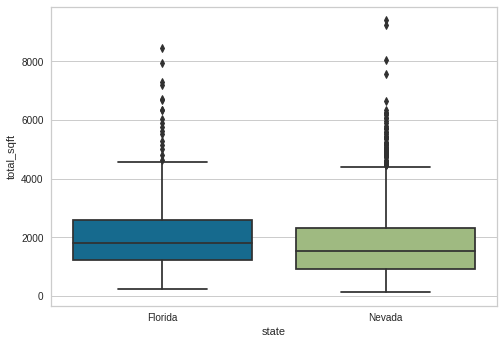

In [ ]:
# lets plot a box plot to compare the distribution of size of houses
combined = pd.concat([florida,nevada])
combined.reset_index(inplace = True, drop=True)
ax = sns.boxplot(x="state", y="total_sqft", data=combined)    
plt.show()

Based on the observation, the houses in Florida are larger than the houses in Nevada. 

To summarize this section,


1.   There is a possible chance that the survey might be collected during the summer time. 

2.   There might be a lack of uniformity in the size of the houses from which the data was collected. 

These assumptions about the data will be useful during feature selection and model design because features related to Air conditioning can be given more importance.



## 3. Data Cleaning

Now let's clean the main survey data to reduce the number of features and make necessary transformations to the features.

In [34]:
variable_information = pd.read_sql("SELECT * FROM variable_information", conn)
variable_information.head(5)

### Observation:

1.  There is a value -2 in several numerical and categorical columns. -2 means Not Applicable and there is no additional information provided about why it is not available.
2.  These values cannot be in certain numerical features. For example, the number of acrooms cannot have the value -2. 

Let's handle the -2 values in numerical columns. We shall treat these values as null values and impute them with their zero, mean or median depending on the data distribution.


In [ ]:
# Handle numerical columns with -2. Let's treat -2 as NA
numerical = variable_information[variable_information['variable_type']=='numerical']
numerical_na = numerical[(numerical['response_labels']=='Not Applicable')|(numerical['response_labels']=='Refuse')|(numerical['response_labels']=="Don't know")]
numerical_na = numerical_na[numerical_na['variable_name']!='doeid']
print('Number of numerical columns with NA:',numerical_na.shape[0])
numerical_na_columns = list(set(numerical_na['variable_name'].values.tolist()))
numerical_na.head(5)

Number of numerical columns with NA: 33


,variable_name,variable_description,response_codes,response_labels,variable_type
4,acrooms,Number of rooms cooled,-2,Not Applicable,numerical
422,bedrooms,Number of bedrooms,-2,Not Applicable,numerical
708,finattrms,Number of finished rooms in the attic,-2,Not Applicable,numerical
710,finbaserms,Number of finished rooms in the basement,-2,Not Applicable,numerical
829,heatroom,Number of rooms heated,-2,Not Applicable,numerical


There are 33 numerical columns with NA (-2) values. Let's find out the distribution of these values in each column.

In [ ]:
survey_data = pd.read_sql("SELECT * FROM survey_data", conn)
for column in numerical_na_columns:
  survey_data.loc[survey_data[column]<0, column] = np.nan
total = survey_data[numerical_na_columns].isnull().sum().sort_values(ascending=False)
percent = (survey_data[numerical_na_columns].isnull().sum()/survey_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data.reset_index(inplace = True)
missing_data.rename(columns = {'index':'variable_name'}, inplace = True)
missing_data.dropna(inplace = True)
missing_data.head(10)

,variable_name,total,percent
0,nocrcash,11988.0,0.992138
1,nkrgalnc,11988.0,0.992138
2,numcords,11983.0,0.991724
3,finattrms,11821.0,0.978317
4,monrfri3,11812.0,0.977572
5,telldays,11033.0,0.913101
6,numapts,10160.0,0.840851
7,numflrs,10160.0,0.840851
8,finbaserms,10102.0,0.836051
9,lgt12ee,9448.0,0.781925


There are a lot of columns where the majority of the values are NA (-2). Let's remove the columns where more than 50 % of the values are NA.

In [ ]:
remove_columns = missing_data[missing_data['percent']>0.5]
remove_columns = remove_columns['variable_name'].values.tolist()
numerical_na_columns = missing_data[missing_data['percent']<0.5]
numerical_na_columns = numerical_na_columns['variable_name'].values.tolist()
survey_data.drop(remove_columns, axis = 1, inplace = True)
print('Number of numerical columns removed:',len(remove_columns))

Number of numerical columns removed: 18


We have removed 18 columns. Now let's explore these numerical columns to find an imputation strategy. First, let's consider the acrooms (no of rooms with AC) column and their distribution. We will also consider the aircond (Presence of an air conditioner column) to help with the analysis.

In [ ]:
ac_data = pd.read_sql("SELECT acrooms, aircond FROM survey_data", conn)
ac_data.head(5)

,acrooms,aircond
0,9,1
1,4,1
2,-2,1
3,7,1
4,-2,0


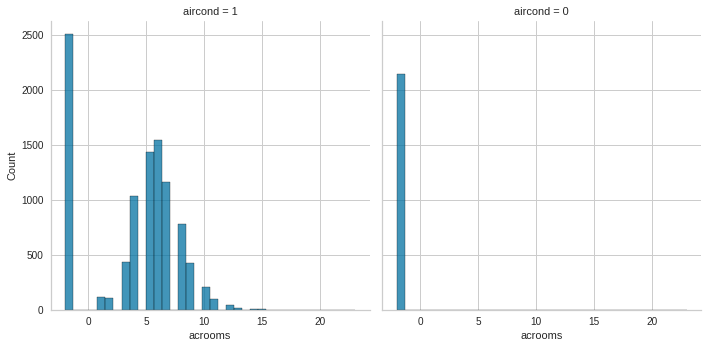

In [ ]:
# plot the distribution of the two columns
sns.displot(data = ac_data, x = 'acrooms',col = 'aircond')

### Observations:



1.   There are NA (-2) values in the acrooms column when the aircond flag is 1 (Yes). Let's impute such values with the median acrooms value. 
2.   We can impute zero in acrooms when the aircond flag is 0 (Yes)




In [ ]:
with_ac = ac_data[(ac_data['aircond']=='1')&(ac_data['acrooms']!=-2)]
ac_median = with_ac['acrooms'].median()
ac_median = int(ac_median)
print("Median value of AC rooms when aircond is true:", ac_median)

Median value of AC rooms when aircond is true: 6


In [ ]:
# Impute values
survey_data.loc[survey_data['aircond']=='0', 'acrooms'] = 0
survey_data.loc[survey_data['acrooms'].isnull(), 'acrooms'] = ac_median

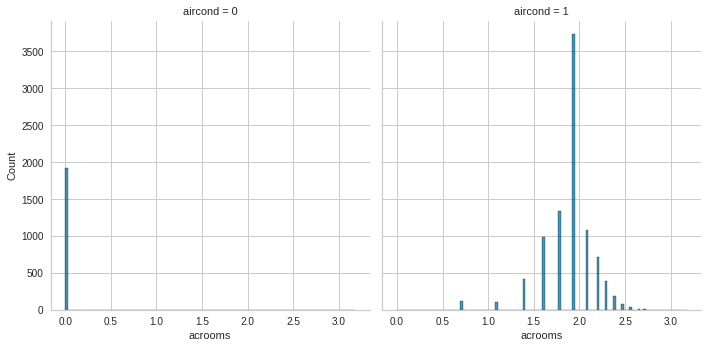

In [ ]:
# Distribution of acrooms after imputing
sns.displot(data = survey_data, x = 'acrooms',col = 'aircond')

Let's find the mean and median and plot the distribution of other numerical columns with NA values to select the appropriate imputation strategy.

In [ ]:
numerical_na_columns.remove('acrooms')
for column in numerical_na_columns:
  print(column)
  #survey_data[column] = survey_data[column].apply(int)
  print("Column name:", column)
  print("Mean:", survey_data[column].mean())
  print("Median:", survey_data[column].median())
  print("***************************************************")

lgt4ee
Column name: lgt4ee
Mean: 1.3993743482794578
Median: 1.0
***************************************************
noutlgtnt
Column name: noutlgtnt
Mean: 0.5697687794777407
Median: 0.0
***************************************************
pcprint
Column name: pcprint
Mean: 0.940754039497307
Median: 1.0
***************************************************
lgt1ee
Column name: lgt1ee
Mean: 1.427029702970297
Median: 1.0
***************************************************
numtherm
Column name: numtherm
Mean: 1.2894890795631826
Median: 1.0
***************************************************
tempgone
Column name: tempgone
Mean: 66.37080003437312
Median: 68.0
***************************************************
tempnite
Column name: tempnite
Mean: 67.68754833720031
Median: 68.0
***************************************************
heatroom
Column name: heatroom
Mean: 5.633324740053278
Median: 6.0
***************************************************
temphome
Column name: temphome
Mean: 69.67517401392

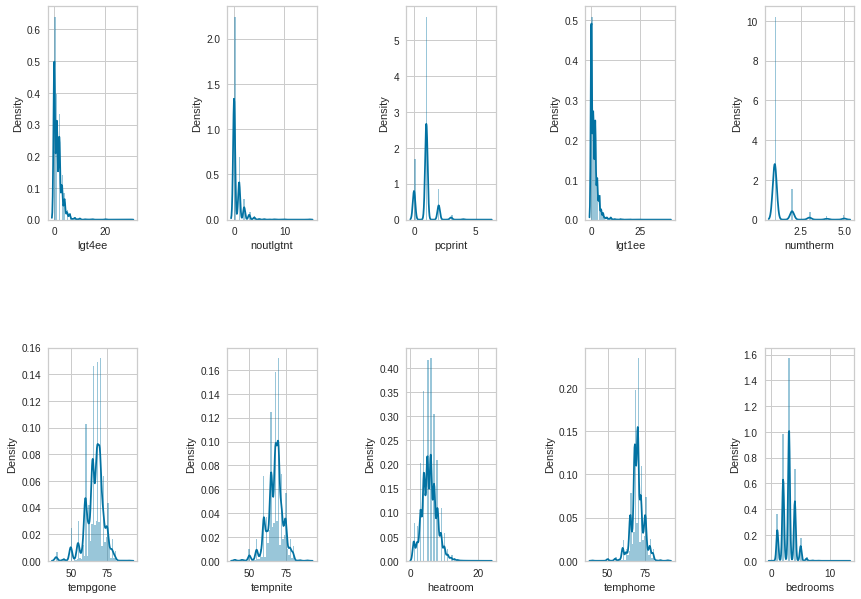

In [ ]:
# Plot the distribution of numerical columns with NA values
n_rows=2
n_cols=5
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=1.5, 
                    wspace=1, 
                    hspace=0.6)
for i, column in enumerate(numerical_na_columns):
    sns.distplot(survey_data[column],ax=axes[i//n_cols,i%n_cols])

The distribution is not normal for all the columns and they are mostly right skewed. So it's better to use the median to impute the NA values.

In [ ]:
# Find the median for each column and impute them
median = survey_data.filter(numerical_na_columns).median()
survey_data[numerical_na_columns]=survey_data[numerical_na_columns].fillna(median.iloc[0])

The numerical columns with NA values have been handled. Let's analyze the categorical columns with -2 values. Here let's also consider -8 (Refuse) and -9 (Don't know) as NA values.



In [ ]:
categorical = variable_information[variable_information['variable_type']=='categorical']
categorical_na = categorical[(categorical['response_labels']=='Not Applicable')|(categorical['response_labels']=='Refuse')|(categorical['response_labels']=="Don't know")]
print('Number of categorical columns with NA:',categorical_na.shape[0])

Number of categorical columns with NA: 349


In [ ]:
categorical_na_columns = set(categorical_na['variable_name'].values.tolist())
for column in categorical_na_columns:
  survey_data.loc[survey_data[column]=='-2', column] = np.nan
  survey_data.loc[survey_data[column]=='-8', column] = np.nan
  survey_data.loc[survey_data[column]=='-9', column] = np.nan
total = survey_data[categorical_na_columns].isnull().sum().sort_values(ascending=False)
percent = (survey_data[categorical_na_columns].isnull().sum()/survey_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data.reset_index(inplace = True)
missing_data.rename(columns = {'index':'variable_name'}, inplace = True)
missing_data.dropna(inplace = True)
missing_data.head(5)

,variable_name,total,percent
0,agehhmemcat13,12079.0,0.999669
1,agehhmemcat14,12079.0,0.999669
2,agehhmemcat12,12077.0,0.999503
3,agehhmemcat11,12072.0,0.999090
4,agehhmemcat10,12064.0,0.998428


There are 349 categorical columns with NA values. To find what these columns mean lets get their information from the database.

In [ ]:
get_column_information(['agehhmemcat14'], conn)

    variable_name                         variable_description response_codes  \
0   agehhmemcat14  Age category of fourteenth household member              1   
1   agehhmemcat14  Age category of fourteenth household member              2   
2   agehhmemcat14  Age category of fourteenth household member              3   
3   agehhmemcat14  Age category of fourteenth household member              4   
4   agehhmemcat14  Age category of fourteenth household member              5   
5   agehhmemcat14  Age category of fourteenth household member              6   
6   agehhmemcat14  Age category of fourteenth household member              7   
7   agehhmemcat14  Age category of fourteenth household member              8   
8   agehhmemcat14  Age category of fourteenth household member              9   
9   agehhmemcat14  Age category of fourteenth household member             10   
10  agehhmemcat14  Age category of fourteenth household member             11   
11  agehhmemcat14  Age categ

The age category of the fourteenth household member might not be an important factor in predicting energy consumption. The top 5 columns are all related to the age category and have 99% of the values as NA. Similar to the numerical columns, let's remove the categorical columns which have more than 50% of their values as NA (-2)

In [ ]:
remove_columns = missing_data[missing_data['percent']>0.5]
remove_columns = remove_columns['variable_name'].values.tolist()
categorical_na_columns = missing_data[missing_data['percent']<0.5]
categorical_na_columns = categorical_na_columns['variable_name'].values.tolist()
survey_data.drop(remove_columns, axis = 1, inplace = True)
print('No of categorical columns removed:',len(remove_columns))

No of categorical columns removed: 186




We have removed 186 columns. Now let's populate the other columns with NA using the mode since mean or median does not apply to categorical features.

In [ ]:
mode = survey_data.filter(categorical_na_columns).mode()
survey_data[categorical_na_columns]=survey_data[categorical_na_columns].fillna(mode.iloc[0])

We can also remove the columns which mention whether the values have been imputed or not. All the imputation column values starts with 'z'.

In [ ]:
imputation_flags = [column for column in survey_data.columns if column[0]=='z']
survey_data.drop(imputation_flags, axis = 1, inplace = True)
print("Dataframe shape:",survey_data.shape)

Dataframe shape: (12083, 377)


We have reduced the number of features to 377. The next step is feature selection.

## 4. Feature Selection

Feature Selection is closely coupled with model selection since the distribution and the relation between the features play a major role in selecting the right model. We can consider linear regression as the model for our data.  But before employing linear regression, we must make sure that the characteristics and the target variable both adhere to its assumptions. The following are the four assumptions of linear regression,



1.  Normality - The distribution of the target variable is assumed to be normal.
2.  Independence - All observations are independent of one another. (Avoid Multicollinearity)
3. Linearity - The relationship between the feature set and the target variable is linear.
4. Homoscedasticity - The variance of residuals is constant.

Let's check if these assumptions are true for our dataset. If not, we will try the popular methods to fix them.



#### 1. Normality:

Let's plot the distribution of the target variable to check if it's normally distributed.

Skewness of the target variable: 2.1141877790374055
Kurtosis of the target variable: 13.917122654448164


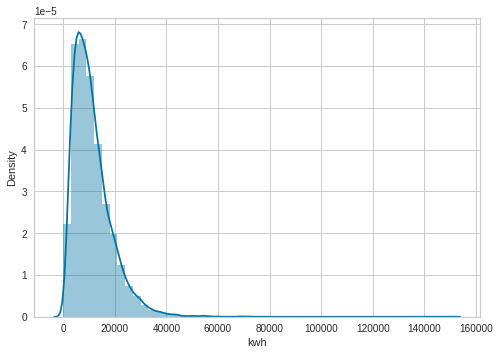

In [ ]:
sns.distplot(survey_data['kwh'])
print("Skewness of the target variable:",skew(survey_data['kwh'], bias = False))
print("Kurtosis of the target variable:",kurtosis(survey_data['kwh'], bias = False))

The target variable 'kwh' is not normally distributed and it's skewed to the right. In such cases, we can take a log transform to fix it.

Skewness of the target variable: -0.5644321972296201
Kurtosis of the target variable: 1.4289389099678909


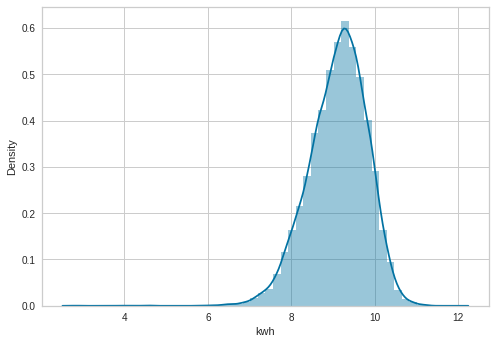

In [ ]:
log_kwh = np.log(survey_data["kwh"])
sns.distplot(log_kwh)
print("Skewness of the target variable:",skew(log_kwh, bias = False))
print("Kurtosis of the target variable:",kurtosis(log_kwh, bias = False))

Taking the log transform has made it skewed to the left. Let's try another strategy known as the box-cox transformation.

Skewness of the target variable: 0.007692133232398941
Kurtosis of the target variable: 0.12738768851634052


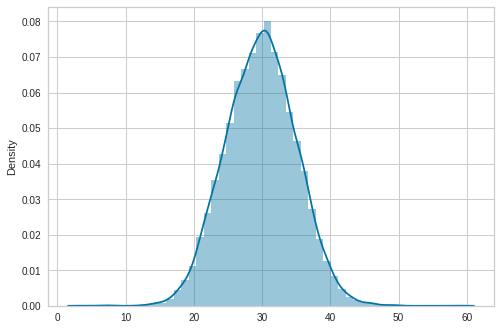

In [ ]:
box_kwh, _ = boxcox(survey_data['kwh'])
sns.distplot(box_kwh)
print("Skewness of the target variable:",skew(box_kwh, bias = False))
print("Kurtosis of the target variable:",kurtosis(box_kwh, bias = False))

The box-cox transform has helped us to fix the distribution of 'kwh' and the skewness is very close to zero.

In [ ]:
survey_data["kwh"], _ = boxcox(survey_data["kwh"])

#### Outlier Removal

Since the target variable is normally distributed now, we can remove values which lies beyond the 3 * standard deviation value on both sides of the curve.

In [ ]:
mean, std = survey_data["kwh"].mean(), survey_data["kwh"].std()

cut_off = 3*std
lower, upper = mean - cut_off, mean + cut_off

outliers = survey_data[(survey_data['kwh'] > upper) | 
                   (survey_data['kwh'] < lower)]
print("Number of outliers:",outliers.shape[0])
outliers.head(5)

,doeid,regionc,division,reportable_domain,typehuq,nweight,hdd65,cdd65,hdd30yr,cdd30yr,...,scaleker,iecc_climate_pub,hdd50,cdd80,gnd_hdd65,wsf,oa_lat,gwt,designdbt99,designdbt1
36,37,3,5,14,2,12153,3981,1573,5443,806,...,-2,4A,1490,104,3809,0,5,58,19,89
59,60,1,1,1,2,5862,6233,514,6839,434,...,-2,5A,3029,0,5598,0,3,50,8,85
128,129,4,10,27,2,8236,6141,716,5427,785,...,-2,5B-5C,2716,31,6074,0,0,52,15,93
308,309,4,9,24,2,9169,1010,4276,703,4606,...,-2,2B,26,1689,483,0,0,69,41,108
368,369,4,10,26,2,7093,916,3313,626,4892,...,-2,3B-4B,18,1821,1585,0,0,69,38,106


In [ ]:
# remove outliers
survey_data = survey_data[(survey_data['kwh'] <= upper) | 
                  (survey_data['kwh'] >= lower)]

In [ ]:
# Function which provides the list of numerical and categorical coluumns
def get_numerical_categorical_column_list(data):
  target_variable = 'kwh'
  processed_column_list = list(data.columns)
  processed_column_list.remove(target_variable)
  processed_column_list.remove('doeid')
  processed_column_tuple = tuple(processed_column_list)
  numerical_variables = pd.read_sql(f"SELECT DISTINCT variable_name FROM variable_information WHERE variable_type = 'numerical' AND variable_name IN {processed_column_tuple}", conn)
  numerical_variables = numerical_variables['variable_name'].values.tolist()
  categorical_variables = pd.read_sql(f"SELECT DISTINCT variable_name FROM variable_information WHERE variable_type = 'categorical' AND variable_name IN {processed_column_tuple}", conn)
  categorical_variables = categorical_variables['variable_name'].values.tolist()
  return numerical_variables, categorical_variables

In [ ]:
numerical_variables, categorical_variables = get_numerical_categorical_column_list(survey_data)

Exploring the distribution of all the numerical features is challenging due to the abundance of features. While working with NA values, we saw the distributions of a few numerical columns, and the distributions weren't normal. We can infer from that observation that the majority of the numerical values share the same characteristics. In order to correct these data, we can log convert them. We can take log (x+1) (add a constant) and then apply a log transformation because the log of zero is infinity. 

Following the selection of the features, we may plot the distributions.

In [ ]:
for column in numerical_variables:
  survey_data = survey_data[survey_data[column]>=0]
  survey_data[column] = survey_data[column].apply(lambda x:np.log(x+1))

#### 2. Independence among observations:

We verify the second assumption of linear regression, lets first analyze the correlations of the features with the target variable using Pearson's correlation.

In [ ]:
correlation_values = pd.DataFrame((survey_data.corr())["kwh"].sort_values(ascending = False)[1:])
correlation_values.reset_index(inplace = True)
correlation_values = correlation_values[['index','kwh']].drop_duplicates()
correlation_values.columns = ['variable_name','kwh']
correlation_values.head(10)

,variable_name,kwh
0,btuel,0.890110
1,dollarel,0.807865
2,kwhoth,0.775649
3,btueloth,0.775605
4,doleloth,0.670559
5,totalbtuoth,0.650564
6,totaldoloth,0.630762
7,totaldol,0.596283
8,kwhrfg,0.560249
9,totalbturfg,0.544586


first value 'btuel' is very highly correlated with the target variable and there are several variables with a similar btu pattern in their names. Let's explore what these columns mean before making a decision.

In [ ]:
top_30_corr = correlation_values['variable_name'].values.tolist()[:30]
get_column_information(top_30_corr, conn)

   variable_name                               variable_description  \
0       bedrooms                                 Number of bedrooms   
1       bedrooms                                 Number of bedrooms   
2       heatroom                             Number of rooms heated   
3       heatroom                             Number of rooms heated   
4       ncombath                           Number of full bathrooms   
5        numcfan                        Number of ceiling fans used   
6       totrooms          Total number of rooms in the housing unit   
7        totsqft  Total square footage (includes all attached ga...   
8     totsqft_en  Total square footage (includes heated/cooled g...   
9         kwhcol  Electricity usage for air-conditioning, centra...   
10        kwhwth  Electricity usage for water heating, in kilowa...   
11        kwhrfg  Electricity usage for refrigerators, in kilowa...   
12        kwhoth  Electricity usage for other purposes (all end-...   
13    

The columns with btu in their names are the same values of kwh but in a different scale (British Thermal Unit). We can remove such columns. There is a good chance that the features are not independent. So let's find the Variance Inflation Factor (VIF) to measure the multicollineartiy.

In [ ]:
X = survey_data[top_30_corr]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data = vif_data.sort_values('VIF', ascending= False)
vif_data["VIF"] = vif_data["VIF"].apply(lambda x: round(x,1))
vif_data.head(20)

,feature,VIF
9,totalbturfg,141278193.1
10,btuelrfg,138824313.6
19,btuelcol,23779920.8
20,totalbtucol,23621037.6
2,kwhoth,3072008.2
3,btueloth,2151658.3
8,kwhrfg,1970730.0
0,btuel,734383.8
4,doleloth,639441.3
16,dolelrfg,571109.9


### Observation:

The values strongly imply that there is no independence between the features. Let's use lasso regression, which penalises the strongly correlated features, to resolve this problem, and visualise the residuals. Understanding the linearity and homoscedasticity will be aided by the residuals. Additionally, as lasso regression employs shrinkage, it will assist in identifying the key features.

In [ ]:
#remove btu columns
btu_columns = [column for column in survey_data.columns if "btu" in column]
survey_data.drop(btu_columns,axis = 1,  inplace = True)
print(btu_columns)

['btuel', 'btuelsph', 'btuelcol', 'btuelwth', 'btuelrfg', 'btueloth', 'btung', 'btungsph', 'btungwth', 'btungoth', 'btulp', 'btulpsph', 'btulpwth', 'btulpoth', 'btufo', 'btufosph', 'btufowth', 'btufooth', 'btuker', 'btukersph', 'btukerwth', 'btukeroth', 'btuwood', 'totalbtu', 'totalbtusph', 'totalbtucol', 'totalbtuwth', 'totalbturfg', 'totalbtuoth']


Let's remove the features where more than 99% of the values are the same.

In [ ]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for column in df.columns:
        counts = df[column].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99:
            overfit.append(column)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(survey_data)
survey_data.drop(overfitted_features, axis = 1, inplace = True)
print(overfitted_features)

['otherstb2', 'steamr', 'pipeless', 'roomheat', 'carryker', 'range', 'difequip', 'useel', 'elother', 'foilaux', 'foother', 'keroaux', 'krwater', 'krother', 'wdwater', 'solwarm', 'solaraux', 'solwater', 'othwarm', 'otheraux', 'othwater', 'othcook', 'onsite', 'kfuelot', 'gallonfooth', 'btufooth', 'dolfooth', 'gallonkerwth', 'gallonkeroth', 'btukerwth', 'btukeroth', 'dolkerwth', 'dolkeroth', 'wsf']


In [ ]:
numerical_variables, categorical_variables = get_numerical_categorical_column_list(survey_data)

#### One hot encoding and Standardization

Lasso regression requires the categorical variables to be one hot encoded. So let's encode the categorical features. We shall also standardize the numerical features.

In [ ]:
for column in categorical_variables:
  survey_data[categorical_variables] = survey_data[categorical_variables].astype('category')
dummy_variables = pd.get_dummies(survey_data[categorical_variables])
numerical_data = survey_data[numerical_variables]

#### Train-test split

We shall folow the 80-20 train-test split. This will result in 8905 train samples and 2227 test samples. 


In [ ]:
X = pd.concat([numerical_data, dummy_variables], axis = 1)
y = survey_data['kwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [ ]:
print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])

Number of training samples: 8905
Number of test samples: 2227


In [ ]:
# Standardize numerical features.
scaler = StandardScaler().fit(X_train[numerical_variables]) 
X_train[numerical_variables] = scaler.transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

### Lasso regression

We shall use cross validation to find the best alpha value and then use it to train the model

In [ ]:
#Perform CV to find alpha
model = LassoCV(cv=20, random_state=8, max_iter=10000)
model.fit(X_train, y_train)

LassoCV(cv=20, max_iter=10000, random_state=8)

In [ ]:
print("Best alpha value:", model.alpha_)

Best alpha value: 6.864007733282769


In [ ]:
#Fit the model using the best alpha value
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=6.864007733282769)

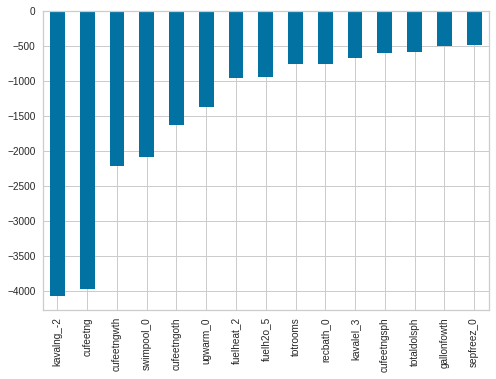

In [ ]:
#Plot the feature importance
pd.Series(lasso_best.coef_, X_train.columns).sort_values(ascending = True)[:15].plot(kind = 'bar')

In [ ]:
feature_importance = pd.DataFrame(lasso_best.coef_, X_train.columns)
feature_importance.reset_index(inplace = True)
feature_importance.columns = ['variable_name','feature_importance']
feature_importance = feature_importance.sort_values('feature_importance')
print(feature_importance.head(20))

           variable_name  feature_importance
435           kavalng_-2        -4077.873053
59              cufeetng        -3977.766502
61           cufeetngwth        -2221.605375
693           swimpool_0        -2090.944282
62           cufeetngoth        -1635.043849
777             ugwarm_0        -1379.123188
368           fuelheat_2         -952.086683
364            fuelh2o_5         -943.774776
28              totrooms         -762.327072
591            recbath_0         -758.625096
434            kavalel_3         -676.883905
60           cufeetngsph         -598.012038
107          totaldolsph         -587.995317
85           gallonfowth         -498.014025
667           sepfreez_0         -478.251714
84           gallonfosph         -464.316605
58              doleloth         -457.646642
73           gallonlpwth         -435.640911
542            pelheat_2         -417.644148
600  reportable_domain_1         -341.144306


All the features are negatively related to the target variable. There seems to be a problem. Let's plot the residuals to analyze further.

In [ ]:
# Print Metrics
print('R squared - Training data', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared - Test data', round(lasso_best.score(X_test, y_test)*100, 2))

R squared - Training data 87.05
R squared - Test data 88.0


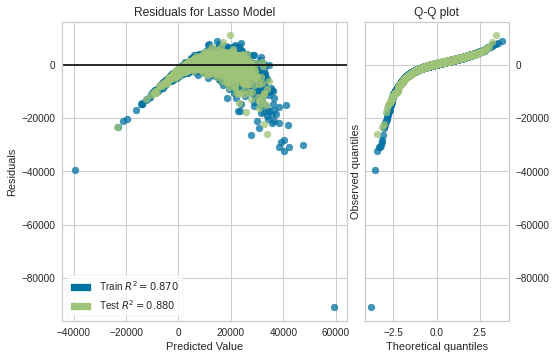

In [ ]:
#Plot residuals
lasso_best = Lasso(alpha=model.alpha_)
visualizer = ResidualsPlot(lasso_best, hist = False, qqplot = True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

### Observation:

*  The residuals are curved which strongly suggests that the data is non-linear. It fails the linearity assumption of linear regression.
*   It's better to pivot to a tree based regression model since it does not expect the linearity between the features and the target variable.





## 6. Model and Feature Selection using Tree based methods

1. Tree-based models do not expect the target variable to be normally 
distributed, so we can ignore the box-cox and log transformation of the target and numerical features respectively.
2. Tree-based models do not expect the categorical variables to be one hot encoded. So let's use label encoding to encode the categorical features.
3. To remove the outliers, we shall use the Inter Quartile Range to measure the spread of the data and remove the values which are to the left of Q1 (quartile 1) - 1.5 * IQR and remove values which are to the right of Q3 (quartile 3) + 1.5 * IQR.



All of the data cleaning techniques have been grouped into a single class to make them easier to use. This class can be used to get the cleaned dataset.

In [5]:
def create_connection(db_file = 'recs_2009_survey.db'):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

class CleanDataset:
  def __init__(self, transform_target_variable, log_numerical_features, do_label_encoding):
    self.transform_target_variable = transform_target_variable
    self.log_numerical_features = log_numerical_features
    self.do_label_encoding = do_label_encoding
    self.conn = create_connection()
    self.survey_data = pd.read_sql("SELECT * FROM survey_data", self.conn)

  def get_columns_with_negative_values(self):

    variable_information = pd.read_sql("SELECT * FROM variable_information", self.conn)
    numerical = variable_information[variable_information['variable_type']=='numerical']
    numerical_na = numerical[(numerical['response_labels']=='Not Applicable')|(numerical['response_labels']=='Refuse')|(numerical['response_labels']=="Don't know")]
    numerical_na = numerical_na[numerical_na['variable_name']!='doeid']
    print('Number of numerical columns with negative values:',numerical_na.shape[0])
    numerical_na_columns = list(set(numerical_na['variable_name'].values.tolist()))
    categorical = variable_information[variable_information['variable_type']=='categorical']
    categorical_na = categorical[(categorical['response_labels']=='Not Applicable')|(categorical['response_labels']=='Refuse')|(categorical['response_labels']=="Don't know")]
    print('Number of categorical columns with negative values:',categorical_na.shape[0])
    categorical_na_columns = list(set(categorical_na['variable_name'].values.tolist()))

    return numerical_na_columns, categorical_na_columns

  def handle_numerical_negative_values(self, numerical_na_columns):

    for column in numerical_na_columns:
      self.survey_data.loc[self.survey_data[column]<0, column] = np.nan
    
    total = self.survey_data[numerical_na_columns].isnull().sum().sort_values(ascending=False)
    percent = (self.survey_data[numerical_na_columns].isnull().sum()/self.survey_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
    missing_data.reset_index(inplace = True)
    missing_data.rename(columns = {'index':'variable_name'}, inplace = True)
    missing_data.dropna(inplace = True)
    remove_columns = missing_data[missing_data['percent']>0.5]
    remove_columns = remove_columns['variable_name'].values.tolist()
    self.survey_data.drop(remove_columns, axis = 1, inplace = True)
    print("No. of numerical columns removed:", len(remove_columns))
    numerical_columns = missing_data[missing_data['percent']<0.5]
    numerical_columns = numerical_columns['variable_name'].values.tolist()
    with_ac = self.survey_data[(self.survey_data['aircond']=='1')&(self.survey_data['acrooms']!=-2)]
    ac_median = with_ac['acrooms'].median()
    ac_median = int(ac_median)
    self.survey_data.loc[self.survey_data['aircond']=='0', 'acrooms'] = 0
    self.survey_data.loc[self.survey_data['acrooms'].isnull(), 'acrooms'] = ac_median
    numerical_columns.remove('acrooms')
    median_value = self.survey_data.filter(numerical_columns).median()
    self.survey_data[numerical_columns]=self.survey_data[numerical_columns].fillna(median_value.iloc[0])

  def handle_categorical_negative_values(self, categorical_na_columns):

    for column in categorical_na_columns:
      self.survey_data.loc[self.survey_data[column]=='-2', column] = np.nan
      self.survey_data.loc[self.survey_data[column]=='-8', column] = np.nan
      self.survey_data.loc[self.survey_data[column]=='-9', column] = np.nan
      self.survey_data.loc[self.survey_data[column]==-2, column] = np.nan
      self.survey_data.loc[self.survey_data[column]==-8, column] = np.nan
      self.survey_data.loc[self.survey_data[column]==-9, column] = np.nan

    total = self.survey_data[categorical_na_columns].isnull().sum().sort_values(ascending=False)
    percent = (self.survey_data[categorical_na_columns].isnull().sum()/self.survey_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
    missing_data.reset_index(inplace = True)
    missing_data.rename(columns = {'index':'variable_name'}, inplace = True)
    missing_data.dropna(inplace = True)
    remove_columns = missing_data[missing_data['percent']>0.5]
    remove_columns = remove_columns['variable_name'].values.tolist()
    self.survey_data.drop(remove_columns, axis = 1, inplace = True)
    print("No of categorical columns removed:", len(remove_columns))
    categorical_columns = missing_data[missing_data['percent']<0.5]
    categorical_columns = categorical_columns['variable_name'].values.tolist()
    mode_value = self.survey_data.filter(categorical_columns).mode()
    self.survey_data[categorical_columns]=self.survey_data[categorical_columns].fillna(mode_value.iloc[0])


  def remove_imputation_flags(self):

    imputation_flags = [column for column in self.survey_data.columns if column[0]=='z']
    self.survey_data.drop(imputation_flags, axis = 1, inplace = True)

  def perform_box_cox_transform(self, column):

    self.survey_data[column], _ = boxcox(self.survey_data[column])


  def perform_log_transform_features(self):

    numerical_columns, _ = self.get_current_columns_list()
    for column in numerical_columns:
      self.survey_data = self.survey_data[self.survey_data[column]>=0]
      self.survey_data[column] = self.survey_data[column].apply(lambda x:np.log(x+1))

  def subset_by_iqr(self, df, column, whisker_width=1.5):

      q1 = df[column].quantile(0.25)                 
      q3 = df[column].quantile(0.75)
      iqr = q3 - q1
      filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
      return df.loc[filter]
    
  def remove_outliers(self):

    numerical_columns, _ = self.get_current_columns_list()
    for column in numerical_columns:
      self.survey_data = self.survey_data[self.survey_data[column]>=0]

    if self.transform_target_variable:
      mean, std = self.survey_data["kwh"].mean(), self.survey_data["kwh"].std()
      cut_off = 3*std
      lower, upper = mean - cut_off, mean + cut_off
      outliers = self.survey_data[(self.survey_data['kwh'] > upper) | (self.survey_data['kwh'] < lower)]
      self.survey_data = self.survey_data[(self.survey_data['kwh'] <= upper) | (self.survey_data['kwh'] >= lower)]
    else:
      self.survey_data = self.subset_by_iqr(self.survey_data, "kwh", whisker_width=1.5)

  def overfit_reducer(self):
      """
      This function takes in a dataframe and returns a list of features that are overfitted.
      """
      overfit = []
      for column in self.survey_data.columns:
          counts = self.survey_data[column].value_counts()
          zeros = counts.iloc[0]
          if zeros / len(self.survey_data) * 100 > 90:
              overfit.append(column)
      overfit = list(overfit)
      self.survey_data.drop(overfit, axis = 1, inplace = True)


  def get_current_columns_list(self):

      target_variable = 'kwh'
      id_variable = "doeid"
      processed_column_list = list(self.survey_data.columns)
      processed_column_list.remove(target_variable)
      processed_column_list.remove(id_variable)
      processed_column_tuple = tuple(processed_column_list)
      numerical_variables = pd.read_sql(f"SELECT DISTINCT variable_name FROM variable_information WHERE variable_type = 'numerical' AND variable_name IN {processed_column_tuple}", self.conn)
      numerical_variables = list(set(numerical_variables['variable_name'].values.tolist()))
      categorical_variables = pd.read_sql(f"SELECT DISTINCT variable_name FROM variable_information WHERE variable_type = 'categorical' AND variable_name IN {processed_column_tuple}", self.conn)
      categorical_variables = list(set(categorical_variables['variable_name'].values.tolist()))

      return numerical_variables, categorical_variables

  def perform_label_encoding(self):
      _, categorical_variables = self.get_current_columns_list()
      labelencoder = LabelEncoder()
      for column in categorical_variables:
        self.survey_data[column] = labelencoder.fit_transform(self.survey_data[column])


  def cast_string_as_categorical(self):

      _, categorical_variables = self.get_current_columns_list()
      for column in categorical_variables:
        self.survey_data[categorical_variables] = self.survey_data[categorical_variables].astype('category')

  def remove_btu_columns(self):
      btu_columns = [column for column in self.survey_data.columns if "btu" in column]
      self.survey_data.drop(btu_columns,axis = 1,  inplace = True)

  def clean(self):
      numerical_na_columns, categorical_na_columns = self.get_columns_with_negative_values()
      self.handle_numerical_negative_values(numerical_na_columns)
      self.handle_categorical_negative_values(categorical_na_columns)
      self.remove_imputation_flags()
      self.remove_btu_columns()
      if self.transform_target_variable:
        self.perform_box_cox_transform("kwh")
      if self.log_numerical_features:
        self.perform_log_transform_features()
      self.remove_outliers()
      self.overfit_reducer()
      self.cast_string_as_categorical()
      if self.do_label_encoding:
        self.perform_label_encoding()
      print("Final DataFrame shape after cleaning:", self.survey_data.shape)
      return self.survey_data

In [7]:
# Get Cleaned Dataset
cleaner = CleanDataset(transform_target_variable = False, log_numerical_features = False, do_label_encoding = True)
clean_survey_data = cleaner.clean()
clean_survey_data.head()

Number of numerical columns with negative values: 33
Number of categorical columns with negative values: 349
No. of numerical columns removed: 18
No of categorical columns removed: 186
Final DataFrame shape after cleaning: (10769, 233)


,doeid,regionc,division,reportable_domain,typehuq,nweight,hdd65,cdd65,hdd30yr,cdd30yr,...,periodng,scaleng,iecc_climate_pub,hdd50,cdd80,gnd_hdd65,oa_lat,gwt,designdbt99,designdbt1
0,1,1,4,3,1,2471,4742,1080,4953,1271,...,0,0,5,2117,56,4250,6,56,9,96
1,2,3,1,18,1,8599,2662,199,2688,143,...,1,1,4,62,26,2393,0,64,38,73
2,3,0,0,0,4,8969,6233,505,5741,829,...,5,4,7,2346,49,5654,3,52,12,88
3,4,1,3,24,1,18003,6034,672,5781,868,...,5,4,7,2746,0,4941,4,55,7,87
4,5,0,0,0,2,5999,5388,702,5313,797,...,1,1,7,2251,0,5426,4,50,13,90


We shall use the same 80-20 strategy to split the data into train and test.

In [8]:
y = clean_survey_data['kwh']
all_features = list(clean_survey_data.columns)
all_features.remove('doeid')
all_features.remove('kwh')
X_train, X_test, y_train, y_test = train_test_split(clean_survey_data[all_features], y, test_size=0.2, random_state=8)

In [ ]:
print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])

Number of training samples: 8615
Number of test samples: 2154


The new number of training samples are 8615 and test samples are 2154. This is because we have used IQR (Inter Quartile Range) to remove the outliers for this method.

### Feature Selection using Random Forest Regressor

We shall use the SelectFromModel class to select the best features using random forest regressor.

In [ ]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100, random_state=8))
sel.fit(X_train, y_train)
selected_feat= list(X_train.columns[(sel.get_support())])
print(selected_feat)

['regionc', 'division', 'fuelheat', 'kwhsph', 'kwhcol', 'kwhwth', 'kwhoth', 'dollarel']


In [ ]:
# Print the selected features with feature importance
selected_features = pd.DataFrame(sel.estimator_.feature_importances_.ravel(), X_train.columns.ravel())
selected_features.reset_index(inplace =True)
selected_features.columns = ['features','importance_value']
selected_features = selected_features.sort_values('importance_value',ascending = False)
selected_features.head(len(selected_feat))

,features,importance_value
197,dollarel,0.662358
196,kwhoth,0.165652
192,kwhsph,0.043734
193,kwhcol,0.033819
194,kwhwth,0.025305
1,division,0.019730
108,fuelheat,0.009736
0,regionc,0.004772


There are so many columns prefixed with kwh.Let's explore what these columns mean.

In [ ]:
get_column_information(selected_feat, conn)

   variable_name                               variable_description  \
0       division                                    Census Division   
1       division                                    Census Division   
2       division                                    Census Division   
3       division                                    Census Division   
4       division                                    Census Division   
5       division                                    Census Division   
6       division                                    Census Division   
7       division                                    Census Division   
8       division                                    Census Division   
9       division                                    Census Division   
10      fuelheat                            Main space heating fuel   
11      fuelheat                            Main space heating fuel   
12      fuelheat                            Main space heating fuel   
13    

All the columns prefixed with kwh measure the energy consumption of the individual components like AC, other appliances etc. Let's see if these values add up to kwh.

In [ ]:
kwh_columns = [column for column in clean_survey_data.columns if "kwh" in column]
clean_survey_data[kwh_columns].head(5)

,kwh,kwhsph,kwhcol,kwhwth,kwhrfg,kwhoth
0,18466,3186,3068,2968,1515,7726
1,5148,0,182,0,1310,3655
2,2218,0,184,0,915,1117
3,10015,0,1063,1887,1670,5393
4,2869,0,0,0,346,2522


All the individual values approximately add up to the total electricity consumption. In the real world, it is most likely that we won't have access to the energy consumption of the individual components or there might be a case where we might get just one or two components and not all. If we have all these features it will be very likely that we could calculate the electricity consumption by adding the electricity consumption of other components. 

There are two ways to go about it, 


1.  Either drop all the individual energy consumption components
2.  Randomly select 1 or 2 individual energy consumption components and develop a model.

Let's assume that we won't have any of these individual energy consumption components as a part of our data which might be the most likely scenario in a real world setting.



In [ ]:
kwh_columns.remove("kwh")
y = clean_survey_data['kwh']
remove_columns = ['doeid','kwh'] + kwh_columns
features = [column for column in clean_survey_data.columns if column not in remove_columns]
X = clean_survey_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [ ]:
# Select features after removing col
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100, random_state=8))
sel.fit(X_train, y_train)
selected_feat= list(X_train.columns[(sel.get_support())])
print(selected_feat)

['regionc', 'division', 'reportable_domain', 'nweight', 'hdd65', 'hdd30yr', 'cdd30yr', 'dollarel', 'dolelsph', 'hdd50']


In [ ]:
get_column_information(selected_feat, conn)

        variable_name                               variable_description  \
0            division                                    Census Division   
1            division                                    Census Division   
2            division                                    Census Division   
3            division                                    Census Division   
4            division                                    Census Division   
5            division                                    Census Division   
6            division                                    Census Division   
7            division                                    Census Division   
8            division                                    Census Division   
9            division                                    Census Division   
10            regionc                                      Census Region   
11            regionc                                      Census Region   
12          

We shall remove 'hdd50'column since it measures the same value as 'hdd65' but on a different scale. We shall also remove the nweights column which is not useful to our model.

In [ ]:
selected_feat.remove("hdd50")
selected_feat.remove("nweight")
selected_features = pd.DataFrame(sel.estimator_.feature_importances_.ravel(), X_train.columns.ravel())
selected_features.reset_index(inplace =True)
selected_features.columns = ['features','importance_value']
selected_features = selected_features[selected_features['features']!='nweight']
selected_features = selected_features.sort_values('importance_value',ascending = False)
selected_features.head(len(selected_feat))

,features,importance_value
192,dollarel,0.775531
1,division,0.039144
0,regionc,0.029513
219,hdd50,0.016068
2,reportable_domain,0.009313
8,cdd30yr,0.007156
193,dolelsph,0.006444
5,hdd65,0.005989


In [ ]:
X = clean_survey_data[selected_feat]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=8)

A model class has been defined which helps in training the model, calculating the results, plotting the residuals and storing the results.

In [14]:
class Model:
  def __init__(self,regressor, X_train, y_train, X_test, y_test, return_metrics = False, save_predictions = False):
    self.regressor = regressor
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.return_metrics = metrics
    self.save_predictions = save_predictions
  
  def calculate_results(self, y_true, y_pred):

    r2 = metrics.r2_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    print('R^2:',r2)
    print('MAE:',mae)
    return r2, mae

  def train_model(self):

    results = {"train":{"r2":0, "mae":0},
               "test":{"r2":0, "mae":0}}
    print("Training Model")
    self.regressor.fit(self.X_train, self.y_train)
    y_train_pred = self.regressor.predict(self.X_train)
    print("Training Results:")
    results["train"]["r2"], results["train"]["mae"] = self.calculate_results(self.y_train, y_train_pred)
    print("Making Predictions")
    y_pred = self.regressor.predict(self.X_test)
    print("Test Results:")
    results["test"]["r2"], results["test"]["mae"] = self.calculate_results(self.y_test, y_pred)
    if self.return_metrics:
      return results
    if self.save_predictions:
      self.store_predictions(y_pred)

  def plot_visualizer(self):
    visualizer = ResidualsPlot(self.regressor, hist = False, qqplot = True)
    visualizer.fit(self.X_train, self.y_train)
    visualizer.score(self.X_test, self.y_test)
    visualizer.show()

  def store_predictions(self, y_pred):
    y_pred_df = pd.DataFrame(y_pred, columns = ['kwh_predicted'])
    predictions = pd.concat([self.X_test,y_pred_df],axis = 1)
    predictions.to_csv('predicted_results.csv',index = False)

In [ ]:
# Lets aggregate all the results in a list for comparison
results = []

### Model Selection:

We shall use four tree based regressors and compare their performance to select the best model. The following are the four models considered,

1. Random Forest Regressor
2. XGBoost Regressor
3. Gradient Boosting Regressor
4. AdaBoost Regressor

We shall run the models using the default parameters and later fine tune the model with the best performance to select the appropriate parameters.

### Error Metrics:

We shall consider the following two metrics to evaluate the performance of the model,

1.  R^2 error - Helps in measuring the goodness of fit and comparing the performance of models.
2.  Mean Absolute Error - Helps in finding out the value by which the predictions are wrong (eg: by 500 kwh).




#### 1. Random Forest Regressor:

Training Model
Training Results:
R^2: 0.9875004815081907
MAE: 456.9853267556587
Making Predictions
Test Results:
R^2: 0.9085499673872973
MAE: 1211.4618848653665


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


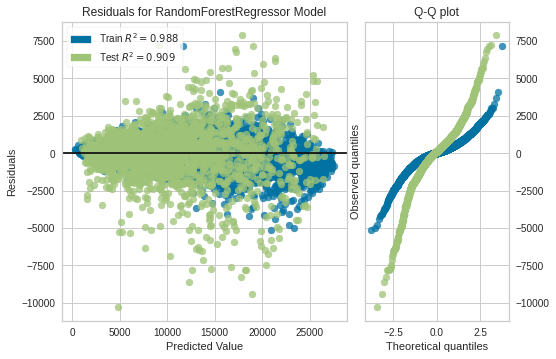

In [ ]:
rfr = RandomForestRegressor()
rf_model = Model(rfr, X_train, y_train, X_test, y_test, return_metrics = True)
rfr_results = rf_model.train_model()
rf_model.plot_visualizer()
results.append(["Random Forest",rfr_results["train"]["r2"], rfr_results["train"]["mae"],rfr_results["test"]["r2"], rfr_results["test"]["mae"]])

### Observation:



1.   The model is clearly overfitting where the train r^2 value is much higher compared to the test r^2 value. 



### 2. XGBoost Regressor


Training Model
[22:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Results:
R^2: 0.9091961207493134
MAE: 1286.493729376281
Making Predictions
Test Results:
R^2: 0.8983509061238224
MAE: 1292.9246381017601


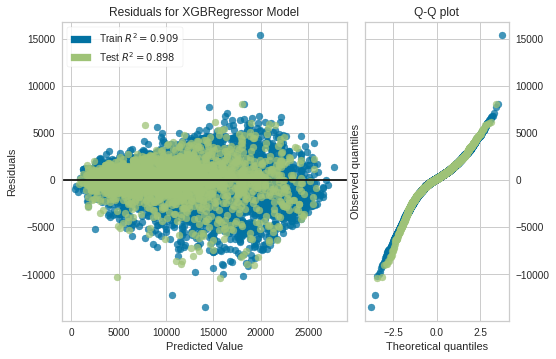

In [ ]:
xgb = XGBRegressor()
xgb_model = Model(xgb, X_train, y_train, X_test, y_test, return_metrics = True)
xgb_results = xgb_model.train_model()
xgb_model.plot_visualizer()
results.append(["XGBoost",xgb_results["train"]["r2"], xgb_results["train"]["mae"],xgb_results["test"]["r2"], xgb_results["test"]["mae"]])

### Observation:


1.  The model does not overfit.
2.  There seems to be a funnel-shaped pattern (variance of the residuals increases as the value increases) and also an outlier in the train data. This has occurred even after removing the outliers using IQR.



### 3. Gradient Boosting Regressor


Training Model
Training Results:
R^2: 0.9090897367311594
MAE: 1283.8780591762086
Making Predictions
Test Results:
R^2: 0.896802955750372
MAE: 1302.8734536440186


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


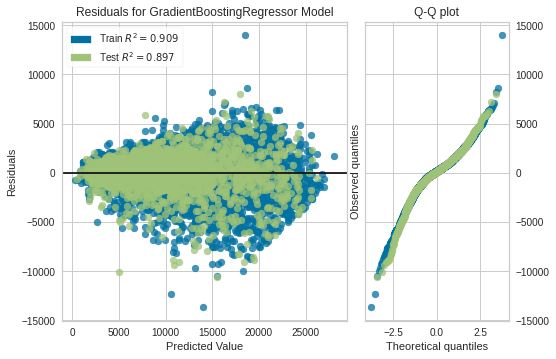

In [ ]:
gbr = GradientBoostingRegressor()
gbr_model = Model(gbr, X_train, y_train, X_test, y_test, return_metrics = True)
gbr_results = gbr_model.train_model()
gbr_model.plot_visualizer()
results.append(["Gradient Boosting",gbr_results["train"]["r2"], gbr_results["train"]["mae"],gbr_results["test"]["r2"], gbr_results["test"]["mae"]])

### Observation:

1.  Follows the same pattern as XG Boost regressor.
2.  The model does not overfit.
2.  There seems to be a funnel-shaped pattern and also an outlier in the train data. This has occurred even after removing the outliers using IQR.

### 4. AdaBoost Regressor

Training Model
Training Results:
R^2: 0.7872462625336067
MAE: 2271.360042341094
Making Predictions
Test Results:
R^2: 0.7679478233687179
MAE: 2256.9080611162076


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  "X does not have valid feature names, but"


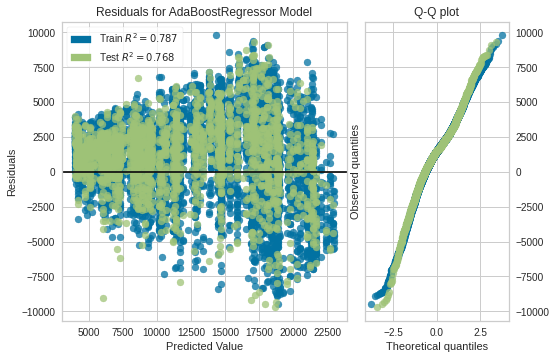

In [ ]:
abr = AdaBoostRegressor()
abr_model = Model(abr, X_train, y_train, X_test, y_test, return_metrics = True)
abr_results = abr_model.train_model()
abr_model.plot_visualizer()
results.append(["Ada Boost",abr_results["train"]["r2"], abr_results["train"]["mae"],abr_results["test"]["r2"], abr_results["test"]["mae"]])

### Observation:

1. The model also follows a funnel shaped pattern but the variance of the residuals is very high in this model.

### Performance comparison:

In [ ]:
results_df = pd.DataFrame(results, columns = ['Regressor Name','Train R2','Train MAE','Test R2','Test MAE'])
results_df.sort_values('Test R2',ascending = False, inplace = True)
results_df

,Regressor Name,Train R2,Train MAE,Test R2,Test MAE
0,Random Forest,0.987500,456.985327,0.908550,1211.461885
1,XGBoost,0.909196,1286.493729,0.898351,1292.924638
2,Gradient Boosting,0.909090,1283.878059,0.896803,1302.873454
3,Ada Boost,0.787246,2271.360042,0.767948,2256.908061


Among the models, XGBoost Regressor is the best model even though the random forest regressor has a higher r^2 value. This is because the random forest regressor is overfitting and might not perform well on unseen data.

### Finetuning Hyperparameters:

We shall use GridSearchCV to find the best set of hyperparameters for the model and use that to build our final model.

In [ ]:
hyperparameter_grid={ 
            'max_depth': [3,5,7,8],
            'learning_rate': [0.1, 0.05],
            'min_samples_leaf':[3, 5, 9],
            'n_estimators': [50,100,300,500] } 

In [ ]:
xgb = XGBRegressor()

In [ ]:
grid_search = GridSearchCV(xgb, param_grid = hyperparameter_grid, n_jobs = -1, cv=3)
grid_search.fit(X_train, y_train)

[22:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05],
                         'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [3, 5, 9],
                         'n_estimators': [50, 100, 300, 500]})

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 3,
 'n_estimators': 500}

Now that we have identified the best hyperparameters we can build the final model.

## Final Model:

Training Model
[22:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Results:
R^2: 0.939496176546586
MAE: 1046.1017365759496
Making Predictions
Test Results:
R^2: 0.9142254997401886
MAE: 1169.6727353293472


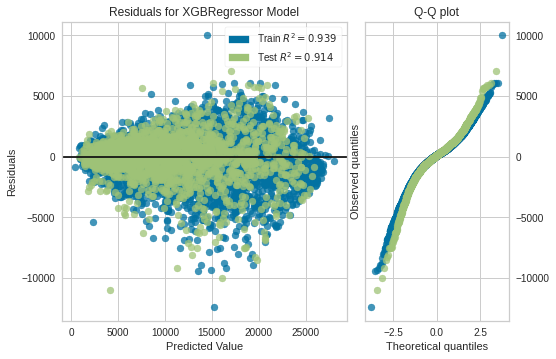

In [ ]:
xgb = XGBRegressor(learning_rate = 0.1, max_depth = 5, min_samples_leaf = 3, n_estimator =  500)
xgb_model = Model(xgb, X_train, y_train, X_test, y_test, return_metrics = True)
xgb_results = xgb_model.train_model()
xgb_model.plot_visualizer()
results.append(["XGBoost",xgb_results["train"]["r2"], xgb_results["train"]["mae"],xgb_results["test"]["r2"], xgb_results["test"]["mae"]])

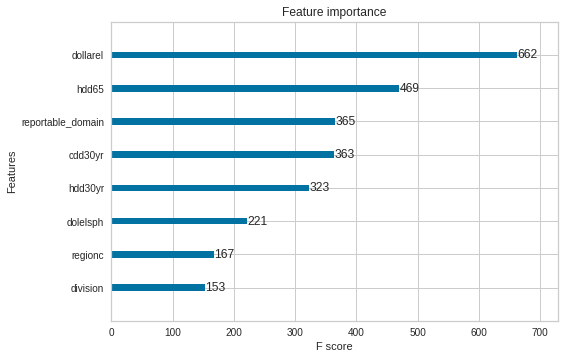

In [ ]:
plot_importance(xgb)

It is obvious that location and heating days are key factors in predicting energy use. However, if we take a closer look, the model does not account for the specifics of the property, such as size, number of air-conditioned rooms, and heating system consumption. Along with the location and climate, they have a significant impact on energy use in the real world. Since it is believed that the data would be gathered in the summer, let's add a few specific house parts to the features and see whether the outcomes are improved.

In [11]:
selected_features = ['regionc', 'division', 'reportable_domain', 'hdd65', 'hdd30yr', 'cdd30yr','dollarel','dolelsph']
manually_selected_features = ['totrooms', 'heatroom', 'acrooms', 'totsqft', 'metromicro', 'ur'] 
final_features = selected_features + manually_selected_features

In [12]:
X = clean_survey_data[final_features]
y = clean_survey_data['kwh']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=8)

Training Model
[23:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Results:
R^2: 0.9438659793515747
MAE: 1012.6002767163242
Making Predictions
Test Results:
R^2: 0.9160191599566048
MAE: 1169.1332322654619


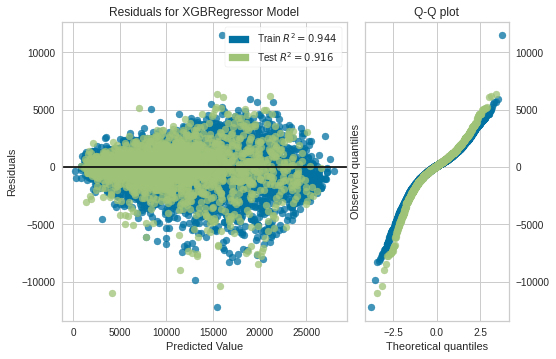

In [15]:
xgb = XGBRegressor(learning_rate = 0.1, max_depth = 5, min_samples_leaf = 3, n_estimator =  500)
xgb_model = Model(xgb, X_train, y_train, X_test, y_test, return_metrics = True, save_predictions = True)
xgb_results = xgb_model.train_model()
xgb_model.plot_visualizer()

The inclusion of the additional features has resulted in the improvement of the performance by a small margin.

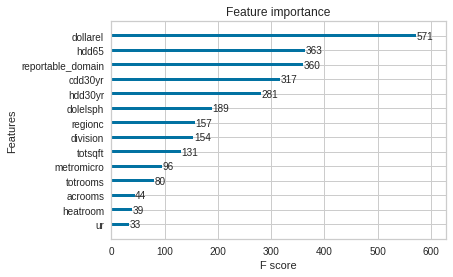

In [ ]:
plot_importance(xgb)

## Performance Evaluation:

1. The model's performance has been enhanced as a result of fine-tuning the hyperparameters. 
2. The test set's mean absolute error is 1169.13 kwh. The predictions made by our model could be off by 1169.13 kwh from the real value. 
3. The data shown in the residuals plot contains a few outliers. This has occurred even after removing the outliers using IQR. To address this problem, the dataset has to be further investigated. 
4. This model is not perfect, and by experimenting with other feature selectors, fine-tuning the hyperparameters, and employing better models, the performance can still be enhanced. 
5. The household's location and the heating degree days are crucial factors in determining energy use.

## Next Iteration:

1. For the next iteration, instead of banking on the feature selection methods, we can take into account the individual components of the house like the appliances used, size of the house and number of members in the household along with the location. We can build a model using these features and see if these features can help in building a better model.

2. We can incorporate one or two of the individual electricity consumption components, such as kwhcol (energy consumption of air conditioners) and kwhoth (energy consumption of other components) and see if it's adding value to the model.

3. Ignore the features which have a non-linear relationship with the target variable and consider features which have a linear relationship with the target variable. This can be verified by using scatter plots with the features on the x-axis and the target variable on the y-axis.